In [1]:
import torch
from torch import nn, optim

from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.preprocessing import LabelEncoder
from sklearn.utils import resample
from sklearn.metrics import accuracy_score, confusion_matrix, matthews_corrcoef, classification_report

import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap, BoundaryNorm
import seaborn as sns
import pandas as pd
import numpy as np
import ast
import math
from Bio import SeqIO

In [2]:
tox = pd.read_excel("../../out/data/blast_embed_tox.xlsx").drop(columns='Unnamed: 0')
tox

,Entry,Protein names,Organism,Protein families,Sequence,Signal peptide,Sequence_noSP,new_protein_family,shortened_label,manual_labels,mmseqs2_label,embed_label,combined
0,Q5Y4W9,U2-agatoxin-Ao1q (U2-AGTX-Ao1q) (Agel_16),Agelena orientalis (Funnel-web spider),Neurotoxin 01 (U2-agtx) family,MRSIISLLLISAMVFSMIAAVPEEEGLQLSEDERGGCLPHNRFCNA...,"SIGNAL 1..20; /evidence=""ECO:0000255""",VPEEEGLQLSEDERGGCLPHNRFCNALSGPRCFSGLRCKELSIWDS...,Agatoxin family,AGTX,0,28,30,"[0.011789458803832531, -0.026637909933924675, ..."
1,Q5Y4V1,U3-agatoxin-Ao1h (U3-AGTX-Ao1h) (Mu-2Aaga_09),Agelena orientalis (Funnel-web spider),"Neurotoxin 07 (Beta/delta-agtx) family, 03 (ag...",MRAIISLLLISTMVFGVIEAVSVQKSLKIFEGERGDCVGESQQCAD...,"SIGNAL 1..20; /evidence=""ECO:0000255""",VSVQKSLKIFEGERGDCVGESQQCADWSGPYCCKGYYCTCQYFPKC...,Agatoxin family,AGTX,0,28,30,"[0.07037654519081116, -0.006755341775715351, 0..."
2,Q5Y4V4,U3-agatoxin-Ao1e (U3-AGTX-Ao1e) (Mu-2Aga_06),Agelena orientalis (Funnel-web spider),"Neurotoxin 07 (Beta/delta-agtx) family, 03 (ag...",MRTIISLLLLSAMVFAVIEAISLEEGLQLFEGERGCVGENQQCADW...,"SIGNAL 1..20; /evidence=""ECO:0000255""",ISLEEGLQLFEGERGCVGENQQCADWAGPHCCSGYYCTCRYFPKCI...,Agatoxin family,AGTX,0,28,30,"[0.06326459348201752, -0.030541636049747467, 0..."
3,Q5Y4V0,U3-agatoxin-Ao1i (U3-AGTX-Ao1i) (Mu-2Aaga_10),Agelena orientalis (Funnel-web spider),"Neurotoxin 07 (Beta/delta-agtx) family, 03 (ag...",MRTIISLLLLSAMVFAEIEAISLEEGLQLFEGERGCVGENQQCANW...,"SIGNAL 1..20; /evidence=""ECO:0000255""",ISLEEGLQLFEGERGCVGENQQCANWAGPHCCSGYYCTCRYFPKCI...,Agatoxin family,AGTX,0,28,30,"[0.04777107760310173, -0.008298294618725777, 0..."
4,Q5Y4U9,U3-agatoxin-Ao1j (U3-AGTX-Ao1j) (Mu-2Aaga_11),Agelena orientalis (Funnel-web spider),"Neurotoxin 07 (Beta/delta-agtx) family, 03 (ag...",MRTIISLLLLSAMVFAVIEAISLEEGLQLFEGERGCVGENQQCADW...,"SIGNAL 1..20; /evidence=""ECO:0000255""",ISLEEGLQLFEGERGCVGENQQCADWARPHCCSGYYCTCRYFPKCI...,Agatoxin family,AGTX,0,28,30,"[0.044718291610479355, -0.013048099353909492, ..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...
5176,B1P1G3,U21-theraphotoxin-Cg1a 3 (U21-TRTX-Cg1a) (Jing...,Chilobrachys guangxiensis (Chinese earth tiger...,"Neurotoxin 10 (Hwtx-1) family, 05 (F4a) subfamily",MKVSVLITLAVLGVMFLLTSAEERGSDQMDSPAWLKSMERIFQSEE...,"SIGNAL 1..21; /evidence=""ECO:0000255""",EERGSDQMDSPAWLKSMERIFQSEERECRWLFGGCEKDSDCCEHLG...,NaN,NaN,-1,34,30,"[-0.0034503983333706856, -0.021120255813002586..."
5177,B1P1G2,U21-theraphotoxin-Cg1a 1 (U21-TRTX-Cg1a) (Jing...,Chilobrachys guangxiensis (Chinese earth tiger...,"Neurotoxin 10 (Hwtx-1) family, 05 (F4a) subfamily",MKVSVLITLAVLGVMFLLTSAEERGSDQMDSPAWLKSMEIIFQSEE...,"SIGNAL 1..21; /evidence=""ECO:0000255""",EERGSDQMDSPAWLKSMEIIFQSEERECRWLFGGCEKDSDCCEHLG...,NaN,NaN,-1,34,30,"[-0.0007040849886834621, -0.015479594469070435..."
5178,P56676,Mu/omega-theraphotoxin-Hs1a (Mu/omega-TRTX-Hs1...,Cyriopagopus schmidti (Chinese bird spider) (H...,"Neurotoxin 10 (Hwtx-1) family, 23 (HwTx-I) sub...",MRASMFLALAGLVLLFVVCYASESEEKEFPRELLFKFFAVDDFKGE...,"SIGNAL 1..21; /evidence=""ECO:0000255""",SESEEKEFPRELLFKFFAVDDFKGEERACKGVFDACTPGKNECCPN...,NaN,NaN,-1,36,24,"[0.04243668168783188, -0.0048881047405302525, ..."
5179,D2Y1Z2,Mu-theraphotoxin-Hhn2q (Mu-TRTX-Hhn2q) (Hainan...,Cyriopagopus hainanus (Chinese bird spider) (H...,"Neurotoxin 10 (Hwtx-1) family, 51 (Hntx-8) sub...",MKASMFLALAGLVLLFVVGYASESEEKEFPRELLSKIFAVDDFKGE...,"SIGNAL 1..21; /evidence=""ECO:0000255""",SESEEKEFPRELLSKIFAVDDFKGEERGCKGFGDSCTPEKNECCPN...,NaN,NaN,-1,36,24,"[0.03860948979854584, -0.008861410431563854, 0..."


In [3]:
regex = pd.read_csv("regex_toxins.csv")
regex

,identifier,Order,Family,Genus,protein_category,Protein families
0,P0CI21,Neogastropoda,Terebridae,Hastula,NaN,NaN
1,P86110,Scorpiones,Hemiscorpiidae,Opisthacanthus,scorpion_ktx,"Short scorpion toxin superfamily, Potassium ch..."
2,O46167,Araneae,Agelenidae,Eratigena,NaN,Helical arthropod-neuropeptide-derived (HAND) ...
3,P83405,Scorpiones,Buthidae,Hottentotta,scorpion_ktx,"Short scorpion toxin superfamily, Potassium ch..."
4,J3SEZ3,Squamata,Viperidae,Crotalus,NaN,Nucleotide pyrophosphatase/phosphodiesterase f...
...,...,...,...,...,...,...
5176,D2Y1Y9,Araneae,Theraphosidae,Cyriopagopus,neurotoxin,"Neurotoxin 10 (Hwtx-1) family, 15 (Hntx-3) sub..."
5177,D2Y1Y0,Araneae,Theraphosidae,Cyriopagopus,neurotoxin,"Neurotoxin 10 (Hwtx-1) family, 15 (Hntx-3) sub..."
5178,D2Y1Z0,Araneae,Theraphosidae,Cyriopagopus,neurotoxin,"Neurotoxin 10 (Hwtx-1) family, 15 (Hntx-3) sub..."
5179,D2Y1Z1,Araneae,Theraphosidae,Cyriopagopus,neurotoxin,"Neurotoxin 10 (Hwtx-1) family, 15 (Hntx-3) sub..."


In [4]:
regex['protein_category'].value_counts()

protein_category
neurotoxin               970
conotoxin                953
three_finger_toxin       480
scorpion_long_toxin      386
phospholipase_a2         280
scorpion_ktx             232
metalloproteinase        176
peptidase                145
scoloptoxin              141
snaclec                  133
venom_kunitz             107
cationic_peptide          86
bradykinin_related        76
mcd_related               74
crisp_related             38
hormone_related           35
ngf                       34
disintegrin               33
phospholipase_other       28
scorpion_short_toxin      26
antimicrobial_peptide     26
venom_protein_other       23
vegf                      18
teretoxin                 16
egf                        7
hainantoxin                7
ficolin                    4
Name: count, dtype: int64

In [5]:
regex = regex.merge(tox[['Entry','combined', 'new_protein_family', 'mmseqs2_label', 'embed_label']], left_on='identifier', right_on='Entry', how='left').drop(columns=['Entry'])
regex

,identifier,Order,Family,Genus,protein_category,Protein families,combined,new_protein_family,mmseqs2_label,embed_label
0,P0CI21,Neogastropoda,Terebridae,Hastula,NaN,NaN,"[0.10342321544885635, 0.09979027509689331, -0....",NaN,-1,-1
1,P86110,Scorpiones,Hemiscorpiidae,Opisthacanthus,scorpion_ktx,"Short scorpion toxin superfamily, Potassium ch...","[0.09271980077028275, -0.04241728410124779, 0....",NaN,-1,-1
2,O46167,Araneae,Agelenidae,Eratigena,NaN,Helical arthropod-neuropeptide-derived (HAND) ...,"[0.060372643172740936, 0.06578557938337326, -0...",NaN,-1,-1
3,P83405,Scorpiones,Buthidae,Hottentotta,scorpion_ktx,"Short scorpion toxin superfamily, Potassium ch...","[0.05040952190756798, -0.02765142172574997, 0....",NaN,-1,-1
4,J3SEZ3,Squamata,Viperidae,Crotalus,NaN,Nucleotide pyrophosphatase/phosphodiesterase f...,"[0.016922470182180405, 0.06756942719221115, 0....",NaN,-1,26
...,...,...,...,...,...,...,...,...,...,...
5176,D2Y1Y9,Araneae,Theraphosidae,Cyriopagopus,neurotoxin,"Neurotoxin 10 (Hwtx-1) family, 15 (Hntx-3) sub...","[0.013212435878813267, -9.744058479554951e-05,...","Neurotoxin 10 (Hwtx-1, Hntx-1/3) family",36,24
5177,D2Y1Y0,Araneae,Theraphosidae,Cyriopagopus,neurotoxin,"Neurotoxin 10 (Hwtx-1) family, 15 (Hntx-3) sub...","[0.01517461333423853, -0.0043326206505298615, ...","Neurotoxin 10 (Hwtx-1, Hntx-1/3) family",36,24
5178,D2Y1Z0,Araneae,Theraphosidae,Cyriopagopus,neurotoxin,"Neurotoxin 10 (Hwtx-1) family, 15 (Hntx-3) sub...","[0.025634516030550003, 0.011876571923494339, 0...","Neurotoxin 10 (Hwtx-1, Hntx-1/3) family",36,24
5179,D2Y1Z1,Araneae,Theraphosidae,Cyriopagopus,neurotoxin,"Neurotoxin 10 (Hwtx-1) family, 15 (Hntx-3) sub...","[0.011283736675977707, -0.01417932752519846, 0...","Neurotoxin 10 (Hwtx-1, Hntx-1/3) family",36,24


In [6]:
#regex.to_csv("../../data/ProtSpace_csvs/manual.csv", columns=['identifier', 'mmseqs2_label', 'embed_label', 'new_protein_family', 'protein_category'])

In [7]:
regex['combined'].notna().sum() # sanity check

5181

In [8]:
print("Regex labeled Protein count:", regex['protein_category'].notna().sum())
print("Regex unique Protein Families:", len(regex['protein_category'].unique()),'\n',regex['protein_category'].unique(), '\n')
print("Manual labeled Protein count:", regex['new_protein_family'].notna().sum())
print("Manual unique Protein Families:", len(regex['new_protein_family'].unique()),'\n',regex['new_protein_family'].unique(), '\n')

Regex labeled Protein count: 4534
Regex unique Protein Families: 28 
 [nan 'scorpion_ktx' 'conotoxin' 'cationic_peptide' 'mcd_related'
 'neurotoxin' 'scorpion_long_toxin' 'bradykinin_related' 'scoloptoxin'
 'antimicrobial_peptide' 'phospholipase_a2' 'hormone_related' 'egf'
 'ficolin' 'disintegrin' 'vegf' 'scorpion_short_toxin'
 'venom_protein_other' 'metalloproteinase' 'three_finger_toxin'
 'venom_kunitz' 'peptidase' 'teretoxin' 'hainantoxin'
 'phospholipase_other' 'ngf' 'snaclec' 'crisp_related'] 

Manual labeled Protein count: 3213
Manual unique Protein Families: 38 
 [nan 'Conotoxin D superfamily' 'Latarcin, Cytoinsectotoxin family'
 'Cationic peptide 04 (cupiennin) family' 'Natriuretic peptide family'
 'Insulin family' 'Flavin monoamine oxidase family'
 'PDGF/VEGF growth factor family' 'Agatoxin family'
 'Scoloptoxin-16 family' 'Venom protein 11 family'
 'Conotoxin I2 superfamily' 'Short scorpion toxin superfamily'
 'Neurotoxin 10 (Hwtx-1) 51 (Hntx-8) family'
 'Neurotoxin 10 (Hwtx-

In [97]:
identifier_values = ["P0DSI4", "P0DSI5", "P0DSI6", "A0A6M3Z9I6", "P0DX60"]
ant_tox = regex.loc[regex["identifier"].isin(identifier_values), ["identifier", "combined"]]
ant_tox['embedding'] = ant_tox['combined'].apply(ast.literal_eval)

ant_tox

,identifier,combined,embedding
178,A0A6M3Z9I6,"[-0.04453713074326515, 0.00853140652179718, 0....","[-0.04453713074326515, 0.00853140652179718, 0...."
412,P0DSI6,"[0.09179025888442993, 0.017110349610447884, -0...","[0.09179025888442993, 0.017110349610447884, -0..."
418,P0DSI4,"[-0.011715764179825783, 0.005947307217866182, ...","[-0.011715764179825783, 0.005947307217866182, ..."
437,P0DSI5,"[0.0917123481631279, 0.003579158568754792, -0....","[0.0917123481631279, 0.003579158568754792, -0...."
668,P0DX60,"[-0.02099231258034706, 0.03468887135386467, 0....","[-0.02099231258034706, 0.03468887135386467, 0...."


In [98]:
def read_fasta_to_df(file_path):
    records = SeqIO.parse(file_path, "fasta")
    return pd.DataFrame([(rec.id, str(rec.seq)) for rec in records], columns=["identifier", "Sequence"])
def create_fasta(df, output_file):
    with open(output_file, 'w') as f:
        for _, row in df.iterrows():
            f.write(f">{row['identifier']}\n")
            f.write(f"{row['Sequence']}\n")

redundancy_reduced_tox = read_fasta_to_df("../../dataset_generation/MMSeqs2/clustered_db_rep_seq.fasta")
redundancy_reduced_tox

,identifier,Sequence
0,P0CV87,AKKRAGNGCFGLKLDRIGSMSGLGC
1,Q27J49,MFVSRLAASGLLLLALLAVSLDGKPVQQWSHKGWPPRPQIPPLVVQ...
2,Q90Y12,MFVSRLAASGLLLLALLAVSLDGKPLQQWSQRWPHLEIPPLVVQNW...
3,P0DMD6,KLSGCFGFKLDRIGTMSGLGC
4,B3EWY2,SYGISSGCFGLKLDRIGTMSGLGCWRLLQDSP
...,...,...
1283,C0HKG7,MKFSLFFSVFFLAVLHACLSESEIDLEDEEHFMSSDSFLSEIQDES...
1284,B1P1C7,MKTLVLFIIFGLAALFLLSSANELEETERGCGLLMDACDGKSTFCC...
1285,P0DPG5,GVDKEGCRYLLGACTIDDDCCLHLGCNKKYGHCGWDGTF
1286,B1P1G9,MKTSVLVTVLGLAVISVLCSASQDEEQDMYDELLSAVFEVNDELQS...


In [99]:
#nontox = read_fasta_to_df("../../dataset_generation/MMSeqs2/clustered_nontox_rep_seq.fasta")
#nontox = pd.read_csv("../../data/nontox_3000.csv").drop(columns="Unnamed: 0")
#nontox

In [100]:
#create_fasta(nontox, "../../data/nontox_3000.fasta")

In [101]:
#nontox = nontox.sample(3000, random_state=42)

In [102]:
nontox_all = pd.read_csv("../../data/nontox_all_embeds.csv").drop(columns='Unnamed: 0')
nontox_all

,identifier,Sequence,combined
0,A0A023FDY8,ENTQQEEQDYDYGTDTCPFPVLANKTNKAKFVGCHQKCNGGDQKLT...,"[0.055755615234375, 0.0185089111328125, 0.1109..."
1,A0A044RE18,MYWQLVRILVLFDCLQKILAIEHDSICIADVDDACPEPSHTVMRLR...,"[0.0186614990234375, 0.0379638671875, 0.036102..."
2,A0A060XQP6,GTEADNDERAASLLVHLKGDKDGGGLTGSPDGVSAGTTDGTDSSKE...,"[0.10888671875, 0.012176513671875, 0.170166015..."
3,A0A061ACU2,MTVPPLLKSCVVKLLLPAALLAAAIIRPSFLSIGYVLLALVSAVLP...,"[0.036407470703125, -0.059844970703125, 0.0141..."
4,A0A061I403,MPMASVIAVAEPKWISVWGRFLWLTLLSMALGSLLALLLPLGAVEE...,"[0.0618896484375, 0.0238494873046875, -0.02001..."
...,...,...,...
21479,W6RTA4,MSSWFSYFGFSKGPPLEEVREESEEDAQVPEQVVSKNTEEEIADAI...,"[0.1593017578125, 0.0726318359375, 0.033996582..."
21480,X2JAU8,MQPPPRKGNYVKFLKNLHTEQVAKLQLKNQHECDLLEDIRQFTIKR...,"[0.0020542144775390625, -0.0240478515625, 0.04..."
21481,X2JDY8,MGGGKNVRRGLEPLEFEECIVDSPDFRENLNRHEKELDHTSHQIKR...,"[0.0010547637939453125, -0.0033245086669921875..."
21482,X4Y2L4,MKEIAVTIDDKNVIASVSESFHGVAFDASLFSPKGLWSFVDITSPK...,"[0.036163330078125, -0.00980377197265625, 0.02..."


### data filtering

In [103]:
regex = pd.merge(regex, redundancy_reduced_tox[['identifier']], on='identifier', how='inner')
regex

,identifier,Order,Family,Genus,protein_category,Protein families,combined,new_protein_family,mmseqs2_label,embed_label
0,P0CI21,Neogastropoda,Terebridae,Hastula,NaN,NaN,"[0.10342321544885635, 0.09979027509689331, -0....",NaN,-1,-1
1,P86110,Scorpiones,Hemiscorpiidae,Opisthacanthus,scorpion_ktx,"Short scorpion toxin superfamily, Potassium ch...","[0.09271980077028275, -0.04241728410124779, 0....",NaN,-1,-1
2,O46167,Araneae,Agelenidae,Eratigena,NaN,Helical arthropod-neuropeptide-derived (HAND) ...,"[0.060372643172740936, 0.06578557938337326, -0...",NaN,-1,-1
3,P0DP56,Blenniiformes,Blenniidae,Meiacanthus,NaN,Opioid neuropeptide precursor family,"[0.006354116834700108, -0.04091024771332741, 0...",NaN,-1,-1
4,P0DQH7,Neogastropoda,Conidae,Conus,NaN,FARP (FMRFamide related peptide) family,"[0.050173841416835785, 0.06641247123479843, -0...",NaN,-1,-1
...,...,...,...,...,...,...,...,...,...,...
1283,P0DV32,Araneae,Theraphosidae,Acanthoscurria,neurotoxin,"Neurotoxin 14 (magi-1) family, 08 (Ltx-4) subf...","[0.0190198365598917, -0.017574802041053772, 0....",Neurotoxin 14 (magi-1) family,25,19
1284,B6DCL9,Araneae,Lycosidae,Lycosa,neurotoxin,"Neurotoxin 19 (CSTX) family, 04 (U1-Lctx) subf...","[0.00958368182182312, -0.03651665523648262, 0....",Neurotoxin 19 (CSTX) family 01-05,30,20
1285,B6DCR9,Araneae,Lycosidae,Lycosa,neurotoxin,"Neurotoxin 19 (CSTX) family, 01 subfamily","[-0.004791706800460815, -0.03215416893362999, ...",Neurotoxin 19 (CSTX) family 01-05,31,21
1286,Q9U650,Neogastropoda,Conidae,Conus,conotoxin,Conotoxin O1 superfamily,"[0.0035888939164578915, 0.0016561723314225674,...",Conotoxin O1 superfamily,33,30


In [104]:
regex.to_csv("../../data/ProtSpace_csvs/after_redundancy.csv", columns=['identifier', 'protein_category', 'new_protein_family'])

In [105]:
regex_filtered = regex[regex['protein_category'].notna()]
regex_filtered

,identifier,Order,Family,Genus,protein_category,Protein families,combined,new_protein_family,mmseqs2_label,embed_label
1,P86110,Scorpiones,Hemiscorpiidae,Opisthacanthus,scorpion_ktx,"Short scorpion toxin superfamily, Potassium ch...","[0.09271980077028275, -0.04241728410124779, 0....",NaN,-1,-1
5,P85874,Hymenoptera,Vespidae,Polistes,mcd_related,"MCD family, Mastoparan subfamily","[-0.01997099071741104, -0.03772060573101044, 0...",NaN,-1,-1
6,Q0GY42,Scorpiones,Buthidae,Tityus,scorpion_long_toxin,"Long chain scorpion toxin family, Class 2 subf...","[0.06581368297338486, -0.03606785461306572, 0....",NaN,-1,-1
7,P0DQQ6,Neogastropoda,Conidae,Conus,conotoxin,Conotoxin A superfamily,"[0.09076730161905289, 0.09342718869447708, -0....",NaN,-1,-1
10,P0DQT3,Hymenoptera,Vespidae,Parachartergus,mcd_related,"MCD family, Mastoparan subfamily","[0.042670007795095444, -0.028004920110106468, ...",NaN,-1,-1
...,...,...,...,...,...,...,...,...,...,...
1283,P0DV32,Araneae,Theraphosidae,Acanthoscurria,neurotoxin,"Neurotoxin 14 (magi-1) family, 08 (Ltx-4) subf...","[0.0190198365598917, -0.017574802041053772, 0....",Neurotoxin 14 (magi-1) family,25,19
1284,B6DCL9,Araneae,Lycosidae,Lycosa,neurotoxin,"Neurotoxin 19 (CSTX) family, 04 (U1-Lctx) subf...","[0.00958368182182312, -0.03651665523648262, 0....",Neurotoxin 19 (CSTX) family 01-05,30,20
1285,B6DCR9,Araneae,Lycosidae,Lycosa,neurotoxin,"Neurotoxin 19 (CSTX) family, 01 subfamily","[-0.004791706800460815, -0.03215416893362999, ...",Neurotoxin 19 (CSTX) family 01-05,31,21
1286,Q9U650,Neogastropoda,Conidae,Conus,conotoxin,Conotoxin O1 superfamily,"[0.0035888939164578915, 0.0016561723314225674,...",Conotoxin O1 superfamily,33,30


In [106]:
regex_filtered['protein_category'].value_counts()

protein_category
conotoxin                214
neurotoxin               182
scoloptoxin               79
scorpion_long_toxin       70
scorpion_ktx              69
bradykinin_related        50
mcd_related               46
three_finger_toxin        39
cationic_peptide          34
antimicrobial_peptide     15
metalloproteinase         15
venom_kunitz              14
phospholipase_a2          11
scorpion_short_toxin      11
hormone_related            9
teretoxin                  9
snaclec                    8
phospholipase_other        4
disintegrin                4
peptidase                  4
crisp_related              3
venom_protein_other        3
ngf                        2
egf                        2
vegf                       2
hainantoxin                1
ficolin                    1
Name: count, dtype: int64

## put every label with less than 10 samples into the 'other toxins' category

In [107]:
regex_filtered = regex_filtered.copy()
label_counts = regex_filtered['protein_category'].value_counts()

valid_labels = label_counts[label_counts > 10].index
regex_filtered.loc[~regex_filtered['protein_category'].isin(valid_labels), 'protein_category'] = 'other toxins'

regex_filtered['protein_category'].value_counts()

protein_category
conotoxin                214
neurotoxin               182
scoloptoxin               79
scorpion_long_toxin       70
scorpion_ktx              69
other toxins              52
bradykinin_related        50
mcd_related               46
three_finger_toxin        39
cationic_peptide          34
antimicrobial_peptide     15
metalloproteinase         15
venom_kunitz              14
phospholipase_a2          11
scorpion_short_toxin      11
Name: count, dtype: int64

In [108]:
regex_filtered

,identifier,Order,Family,Genus,protein_category,Protein families,combined,new_protein_family,mmseqs2_label,embed_label
1,P86110,Scorpiones,Hemiscorpiidae,Opisthacanthus,scorpion_ktx,"Short scorpion toxin superfamily, Potassium ch...","[0.09271980077028275, -0.04241728410124779, 0....",NaN,-1,-1
5,P85874,Hymenoptera,Vespidae,Polistes,mcd_related,"MCD family, Mastoparan subfamily","[-0.01997099071741104, -0.03772060573101044, 0...",NaN,-1,-1
6,Q0GY42,Scorpiones,Buthidae,Tityus,scorpion_long_toxin,"Long chain scorpion toxin family, Class 2 subf...","[0.06581368297338486, -0.03606785461306572, 0....",NaN,-1,-1
7,P0DQQ6,Neogastropoda,Conidae,Conus,conotoxin,Conotoxin A superfamily,"[0.09076730161905289, 0.09342718869447708, -0....",NaN,-1,-1
10,P0DQT3,Hymenoptera,Vespidae,Parachartergus,mcd_related,"MCD family, Mastoparan subfamily","[0.042670007795095444, -0.028004920110106468, ...",NaN,-1,-1
...,...,...,...,...,...,...,...,...,...,...
1283,P0DV32,Araneae,Theraphosidae,Acanthoscurria,neurotoxin,"Neurotoxin 14 (magi-1) family, 08 (Ltx-4) subf...","[0.0190198365598917, -0.017574802041053772, 0....",Neurotoxin 14 (magi-1) family,25,19
1284,B6DCL9,Araneae,Lycosidae,Lycosa,neurotoxin,"Neurotoxin 19 (CSTX) family, 04 (U1-Lctx) subf...","[0.00958368182182312, -0.03651665523648262, 0....",Neurotoxin 19 (CSTX) family 01-05,30,20
1285,B6DCR9,Araneae,Lycosidae,Lycosa,neurotoxin,"Neurotoxin 19 (CSTX) family, 01 subfamily","[-0.004791706800460815, -0.03215416893362999, ...",Neurotoxin 19 (CSTX) family 01-05,31,21
1286,Q9U650,Neogastropoda,Conidae,Conus,conotoxin,Conotoxin O1 superfamily,"[0.0035888939164578915, 0.0016561723314225674,...",Conotoxin O1 superfamily,33,30


In [109]:
regex_filtered.to_csv("../../data/ProtSpace_csvs/filtered.csv", columns=['identifier', 'protein_category', 'new_protein_family'])

In [110]:
#filtered_out['protein_category'].value_counts()

In [111]:
nontox_all['protein_category'] = 'nontox'
nontox_all

,identifier,Sequence,combined,protein_category
0,A0A023FDY8,ENTQQEEQDYDYGTDTCPFPVLANKTNKAKFVGCHQKCNGGDQKLT...,"[0.055755615234375, 0.0185089111328125, 0.1109...",nontox
1,A0A044RE18,MYWQLVRILVLFDCLQKILAIEHDSICIADVDDACPEPSHTVMRLR...,"[0.0186614990234375, 0.0379638671875, 0.036102...",nontox
2,A0A060XQP6,GTEADNDERAASLLVHLKGDKDGGGLTGSPDGVSAGTTDGTDSSKE...,"[0.10888671875, 0.012176513671875, 0.170166015...",nontox
3,A0A061ACU2,MTVPPLLKSCVVKLLLPAALLAAAIIRPSFLSIGYVLLALVSAVLP...,"[0.036407470703125, -0.059844970703125, 0.0141...",nontox
4,A0A061I403,MPMASVIAVAEPKWISVWGRFLWLTLLSMALGSLLALLLPLGAVEE...,"[0.0618896484375, 0.0238494873046875, -0.02001...",nontox
...,...,...,...,...
21479,W6RTA4,MSSWFSYFGFSKGPPLEEVREESEEDAQVPEQVVSKNTEEEIADAI...,"[0.1593017578125, 0.0726318359375, 0.033996582...",nontox
21480,X2JAU8,MQPPPRKGNYVKFLKNLHTEQVAKLQLKNQHECDLLEDIRQFTIKR...,"[0.0020542144775390625, -0.0240478515625, 0.04...",nontox
21481,X2JDY8,MGGGKNVRRGLEPLEFEECIVDSPDFRENLNRHEKELDHTSHQIKR...,"[0.0010547637939453125, -0.0033245086669921875...",nontox
21482,X4Y2L4,MKEIAVTIDDKNVIASVSESFHGVAFDASLFSPKGLWSFVDITSPK...,"[0.036163330078125, -0.00980377197265625, 0.02...",nontox


In [112]:
regex_filtered = pd.concat([regex_filtered, nontox_all], ignore_index=True)
regex_filtered

,identifier,Order,Family,Genus,protein_category,Protein families,combined,new_protein_family,mmseqs2_label,embed_label,Sequence
0,P86110,Scorpiones,Hemiscorpiidae,Opisthacanthus,scorpion_ktx,"Short scorpion toxin superfamily, Potassium ch...","[0.09271980077028275, -0.04241728410124779, 0....",NaN,-1.0,-1.0,NaN
1,P85874,Hymenoptera,Vespidae,Polistes,mcd_related,"MCD family, Mastoparan subfamily","[-0.01997099071741104, -0.03772060573101044, 0...",NaN,-1.0,-1.0,NaN
2,Q0GY42,Scorpiones,Buthidae,Tityus,scorpion_long_toxin,"Long chain scorpion toxin family, Class 2 subf...","[0.06581368297338486, -0.03606785461306572, 0....",NaN,-1.0,-1.0,NaN
3,P0DQQ6,Neogastropoda,Conidae,Conus,conotoxin,Conotoxin A superfamily,"[0.09076730161905289, 0.09342718869447708, -0....",NaN,-1.0,-1.0,NaN
4,P0DQT3,Hymenoptera,Vespidae,Parachartergus,mcd_related,"MCD family, Mastoparan subfamily","[0.042670007795095444, -0.028004920110106468, ...",NaN,-1.0,-1.0,NaN
...,...,...,...,...,...,...,...,...,...,...,...
22380,W6RTA4,NaN,NaN,NaN,nontox,NaN,"[0.1593017578125, 0.0726318359375, 0.033996582...",NaN,NaN,NaN,MSSWFSYFGFSKGPPLEEVREESEEDAQVPEQVVSKNTEEEIADAI...
22381,X2JAU8,NaN,NaN,NaN,nontox,NaN,"[0.0020542144775390625, -0.0240478515625, 0.04...",NaN,NaN,NaN,MQPPPRKGNYVKFLKNLHTEQVAKLQLKNQHECDLLEDIRQFTIKR...
22382,X2JDY8,NaN,NaN,NaN,nontox,NaN,"[0.0010547637939453125, -0.0033245086669921875...",NaN,NaN,NaN,MGGGKNVRRGLEPLEFEECIVDSPDFRENLNRHEKELDHTSHQIKR...
22383,X4Y2L4,NaN,NaN,NaN,nontox,NaN,"[0.036163330078125, -0.00980377197265625, 0.02...",NaN,NaN,NaN,MKEIAVTIDDKNVIASVSESFHGVAFDASLFSPKGLWSFVDITSPK...


In [113]:
regex_filtered = regex_filtered.copy()  
regex_filtered['embeddings'] = regex_filtered['combined'].apply(ast.literal_eval)
regex_filtered

,identifier,Order,Family,Genus,protein_category,Protein families,combined,new_protein_family,mmseqs2_label,embed_label,Sequence,embeddings
0,P86110,Scorpiones,Hemiscorpiidae,Opisthacanthus,scorpion_ktx,"Short scorpion toxin superfamily, Potassium ch...","[0.09271980077028275, -0.04241728410124779, 0....",NaN,-1.0,-1.0,NaN,"[0.09271980077028275, -0.04241728410124779, 0...."
1,P85874,Hymenoptera,Vespidae,Polistes,mcd_related,"MCD family, Mastoparan subfamily","[-0.01997099071741104, -0.03772060573101044, 0...",NaN,-1.0,-1.0,NaN,"[-0.01997099071741104, -0.03772060573101044, 0..."
2,Q0GY42,Scorpiones,Buthidae,Tityus,scorpion_long_toxin,"Long chain scorpion toxin family, Class 2 subf...","[0.06581368297338486, -0.03606785461306572, 0....",NaN,-1.0,-1.0,NaN,"[0.06581368297338486, -0.03606785461306572, 0...."
3,P0DQQ6,Neogastropoda,Conidae,Conus,conotoxin,Conotoxin A superfamily,"[0.09076730161905289, 0.09342718869447708, -0....",NaN,-1.0,-1.0,NaN,"[0.09076730161905289, 0.09342718869447708, -0...."
4,P0DQT3,Hymenoptera,Vespidae,Parachartergus,mcd_related,"MCD family, Mastoparan subfamily","[0.042670007795095444, -0.028004920110106468, ...",NaN,-1.0,-1.0,NaN,"[0.042670007795095444, -0.028004920110106468, ..."
...,...,...,...,...,...,...,...,...,...,...,...,...
22380,W6RTA4,NaN,NaN,NaN,nontox,NaN,"[0.1593017578125, 0.0726318359375, 0.033996582...",NaN,NaN,NaN,MSSWFSYFGFSKGPPLEEVREESEEDAQVPEQVVSKNTEEEIADAI...,"[0.1593017578125, 0.0726318359375, 0.033996582..."
22381,X2JAU8,NaN,NaN,NaN,nontox,NaN,"[0.0020542144775390625, -0.0240478515625, 0.04...",NaN,NaN,NaN,MQPPPRKGNYVKFLKNLHTEQVAKLQLKNQHECDLLEDIRQFTIKR...,"[0.0020542144775390625, -0.0240478515625, 0.04..."
22382,X2JDY8,NaN,NaN,NaN,nontox,NaN,"[0.0010547637939453125, -0.0033245086669921875...",NaN,NaN,NaN,MGGGKNVRRGLEPLEFEECIVDSPDFRENLNRHEKELDHTSHQIKR...,"[0.0010547637939453125, -0.0033245086669921875..."
22383,X4Y2L4,NaN,NaN,NaN,nontox,NaN,"[0.036163330078125, -0.00980377197265625, 0.02...",NaN,NaN,NaN,MKEIAVTIDDKNVIASVSESFHGVAFDASLFSPKGLWSFVDITSPK...,"[0.036163330078125, -0.00980377197265625, 0.02..."


In [114]:
#print(regex_filtered['embeddings'][20000])

### label preprocessing

In [115]:
X = torch.tensor(regex_filtered['embeddings'].to_list(), dtype=torch.float32)

label_encoder = LabelEncoder()
y = label_encoder.fit_transform(regex_filtered['protein_category'])
y = torch.tensor(y, dtype=torch.long)

# model
## architecture and oversampling

In [116]:
class MLPClassifier(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(MLPClassifier, self).__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(hidden_dim, output_dim)
        self.softmax = nn.Softmax(dim=1)

    def forward(self, x):
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        return x
    
input_dim = X.shape[1] 
hidden_dim = 128
output_dim = len(np.unique(y)) 

## training

Train size: 15669
weights: [1.  1.  1.  1.  1.  1.  1.  0.2 1.  1.  1.  1.  1.  1.  1.  1. ]
class counts: [   11    35    24   150    32    11   128 15038    36     7    55    49
    49     7    27    10]
Epoch [10/100] | Train Loss: 0.5381 | Validation Loss: 0.4882
Epoch [20/100] | Train Loss: 0.3777 | Validation Loss: 0.3366
Epoch [30/100] | Train Loss: 0.2724 | Validation Loss: 0.2408
Epoch [40/100] | Train Loss: 0.1945 | Validation Loss: 0.1729
Epoch [50/100] | Train Loss: 0.1422 | Validation Loss: 0.1284
Epoch [60/100] | Train Loss: 0.1050 | Validation Loss: 0.1046
Epoch [70/100] | Train Loss: 0.0769 | Validation Loss: 0.0907
Epoch [80/100] | Train Loss: 0.0564 | Validation Loss: 0.0839
Epoch [90/100] | Train Loss: 0.0418 | Validation Loss: 0.0816
Epoch [100/100] | Train Loss: 0.0314 | Validation Loss: 0.0800

Validation Accuracy: 0.9890
Validation MCC: 0.8653

Class: antimicrobial_peptide
  Precision: 1.0000
  Recall: 1.0000
  F1-score: 1.0000

Class: bradykinin_related
  Precis

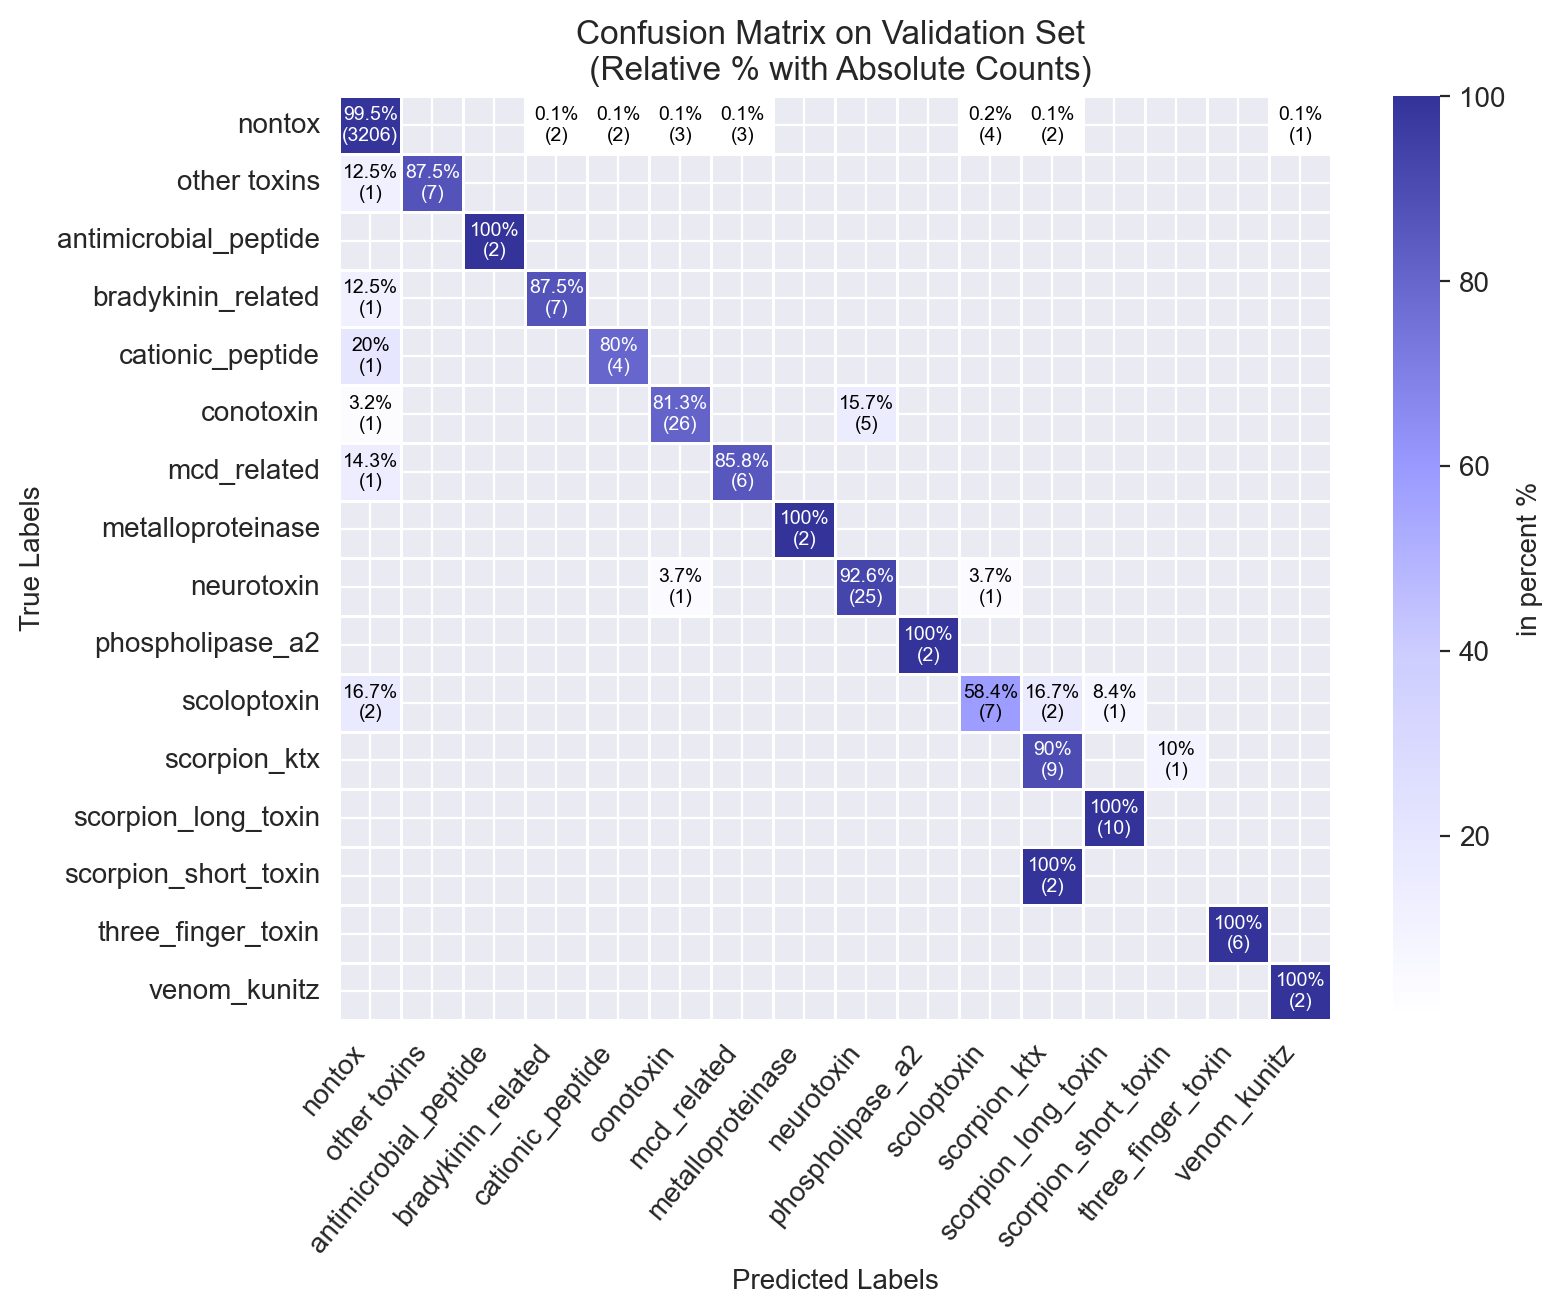


Training Losses:
Epoch 1: 2.7423
Epoch 2: 2.2442
Epoch 3: 1.6351
Epoch 4: 1.0524
Epoch 5: 0.7760
Epoch 6: 0.7183
Epoch 7: 0.6685
Epoch 8: 0.6106
Epoch 9: 0.5693
Epoch 10: 0.5381
Epoch 11: 0.5116
Epoch 12: 0.4880
Epoch 13: 0.4667
Epoch 14: 0.4478
Epoch 15: 0.4324
Epoch 16: 0.4204
Epoch 17: 0.4104
Epoch 18: 0.4006
Epoch 19: 0.3897
Epoch 20: 0.3777
Epoch 21: 0.3657
Epoch 22: 0.3544
Epoch 23: 0.3441
Epoch 24: 0.3344
Epoch 25: 0.3244
Epoch 26: 0.3139
Epoch 27: 0.3029
Epoch 28: 0.2920
Epoch 29: 0.2818
Epoch 30: 0.2724
Epoch 31: 0.2638
Epoch 32: 0.2554
Epoch 33: 0.2466
Epoch 34: 0.2379
Epoch 35: 0.2295
Epoch 36: 0.2219
Epoch 37: 0.2148
Epoch 38: 0.2079
Epoch 39: 0.2011
Epoch 40: 0.1945
Epoch 41: 0.1882
Epoch 42: 0.1823
Epoch 43: 0.1766
Epoch 44: 0.1710
Epoch 45: 0.1657
Epoch 46: 0.1607
Epoch 47: 0.1558
Epoch 48: 0.1510
Epoch 49: 0.1465
Epoch 50: 0.1422
Epoch 51: 0.1381
Epoch 52: 0.1340
Epoch 53: 0.1301
Epoch 54: 0.1262
Epoch 55: 0.1225
Epoch 56: 0.1188
Epoch 57: 0.1152
Epoch 58: 0.1117
Epoch

In [117]:
with open("regex_model_training_output.txt", "w") as f:
    with open("regex_metrics_output.txt", "w") as metrics_file:

        def print_to_file(*args, **kwargs):
            print(*args, **kwargs)
            print(*args, **kwargs, file=f)

            # Save relevant metrics to metrics_file
            if any(term in str(args) for term in ["Accuracy", "MCC", "Precision", "Class:", "F1-score", "Recall"]):
                print(*args, **kwargs, file=metrics_file)

        # Split the data
        X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, test_size=0.15, random_state=42, stratify=y)
        X_train, X_valid, y_train, y_valid = train_test_split(X_train_val, y_train_val, test_size=0.15 / 0.85, random_state=42, stratify=y_train_val)

        print_to_file(f"Train size: {len(X_train)}")

        # Model initialization
        class_counts = np.bincount(y_train.numpy())  
        majority_class_index = np.argmax(class_counts)
        weights = np.ones_like(class_counts, dtype=np.float32)        
        weights[majority_class_index] = 0.2
        weights_tensor = torch.tensor(weights, dtype=torch.float32)

        model = MLPClassifier(input_dim, hidden_dim, output_dim)
        criterion = nn.CrossEntropyLoss(weight=weights_tensor)
        optimizer = optim.Adam(model.parameters(), lr=0.01)
        
        print_to_file(f"weights: {weights}\nclass counts: {class_counts}")

        train_losses = []
        valid_losses = []

        # Early stopping parameters
        patience = 5
        best_valid_loss = float('inf')
        patience_counter = 0

        # Train the model
        num_epochs = 100
        for epoch in range(num_epochs):
            model.train()
            outputs = model(X_train)
            train_loss = criterion(outputs, y_train)

            optimizer.zero_grad()
            train_loss.backward()
            optimizer.step()

            train_losses.append(train_loss.item())

            model.eval()
            with torch.no_grad():
                outputs = model(X_valid)
                valid_loss = criterion(outputs, y_valid)

                valid_losses.append(valid_loss.item())

            if valid_loss.item() < best_valid_loss:
                best_valid_loss = valid_loss.item()
                patience_counter = 0
            else:
                patience_counter += 1

            if patience_counter >= patience:
                print_to_file(f"Early stopping at epoch {epoch + 1}")
                break

            if (epoch + 1) % 10 == 0:
                print_to_file(f"Epoch [{epoch+1}/{num_epochs}] | "
                              f"Train Loss: {train_loss.item():.4f} | "
                              f"Validation Loss: {valid_loss.item():.4f}")

        # Evaluate the model
        model.eval()
        with torch.no_grad():
            outputs = model(X_valid)
            _, predicted = torch.max(outputs, 1)

            accuracy = accuracy_score(y_valid.numpy(), predicted.numpy())
            mcc = matthews_corrcoef(y_valid.numpy(), predicted.numpy())

            # Classification report
            class_report = classification_report(y_valid.numpy(), predicted.numpy(), target_names=label_encoder.classes_, output_dict=True, zero_division=np.nan)

            print_to_file(f"\nValidation Accuracy: {accuracy:.4f}")
            print_to_file(f"Validation MCC: {mcc:.4f}")

            for class_name, metrics in class_report.items():
                if class_name not in ['accuracy', 'macro avg', 'weighted avg']:
                    print_to_file(f"\nClass: {class_name}")
                    print_to_file(f"  Precision: {metrics['precision']:.4f}")
                    print_to_file(f"  Recall: {metrics['recall']:.4f}")
                    print_to_file(f"  F1-score: {metrics['f1-score']:.4f}")

            # Confusion matrix
            # Get predicted and true labels
            predicted_labels = label_encoder.inverse_transform(predicted.numpy())
            true_labels = label_encoder.inverse_transform(y_valid.numpy())
            
            # Compute confusion matrix and percentage matrix
            cm = confusion_matrix(true_labels, predicted_labels)
            cm_percentage = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis] * 100
            
            # Define colors and colormap
            colors = [
                (1, 1, 1),         # White
                (0.9, 0.9, 1),     # Light lilac
                (0.8, 0.8, 1),     # Lilac
                (0.6, 0.6, 1),     # Medium lilac
                (0.4, 0.4, 0.8),   # Deep lilac
                (0.2, 0.2, 0.6),   # Dark lilac
            ]
            cmap = LinearSegmentedColormap.from_list("custom_lilac", colors)
            
            # Define normalization for the colormap
            boundaries = [0, 1, 10, 20, 30, 40, 50, 60, 70, 80, 100]
            norm = BoundaryNorm(boundaries, cmap.N)
            
            # Create the custom order
            custom_order = ["nontox", "other toxins"] + [cls for cls in label_encoder.classes_ if cls not in ["nontox", "other toxins"]]
            
            # Reorder confusion matrix and percentage matrix
            order_indices = [list(label_encoder.classes_).index(cls) for cls in custom_order]
            cm_reordered = cm[np.ix_(order_indices, order_indices)]
            cm_percentage_reordered = cm_percentage[np.ix_(order_indices, order_indices)]
            
            # Create the heatmap
            fig, ax = plt.subplots(figsize=(8, 6), dpi=200)
            
            # Replace zeros with NaN for visualization
            cm_percentage_no_zeros = np.where(cm_reordered == 0, np.nan, cm_percentage_reordered)
            
            sns.heatmap(
                cm_percentage_no_zeros,
                annot=False,
                cmap=cmap,
                xticklabels=custom_order,
                yticklabels=custom_order,
                cbar_kws={'label': 'in percent %'},
                fmt=".0f",
                linewidths=1,
                ax=ax,
            )
            plt.xticks(rotation=50, ha='right') 
            plt.yticks(rotation=0)  
            
            # Add text annotations
            for i in range(cm_reordered.shape[0]):
                for j in range(cm_reordered.shape[1]):
                    if cm_reordered[i, j] > 0:
                        percentage_value = cm_percentage_reordered[i, j]
                        if percentage_value % 1 == 0:
                            relative_text = f"{percentage_value:.0f}%"
                        elif (round(percentage_value, 2) * 10) % 1 == 0:
                            relative_text = f"{percentage_value:.1f}%"
                        else:
                            relative_text = f"{math.ceil(percentage_value * 10) / 10:.1f}%"
            
                        absolute_text = f"{cm_reordered[i, j]:d}"
            
                        background_color = cmap(norm(percentage_value))
                        brightness = (
                            background_color[0] * 0.299 +
                            background_color[1] * 0.587 +
                            background_color[2] * 0.114
                        )
                        font_color = 'white' if brightness < 0.5 else 'black'
            
                        ax.text(
                            j + 0.5, i + 0.5,
                            f"{relative_text}\n({absolute_text})",
                            ha='center', va='center',
                            fontsize=7, color=font_color
                        )
            
            # Titles and labels
            plt.title("Confusion Matrix on Validation Set \n (Relative % with Absolute Counts)")
            plt.xlabel('Predicted Labels')
            plt.ylabel('True Labels')
            
            # Save and show the plot
            plt.savefig("cm_val.png", bbox_inches='tight')
            plt.show()



        print_to_file(f"\nTraining Losses:")
        for epoch, loss in enumerate(train_losses, 1):
            print_to_file(f"Epoch {epoch}: {loss:.4f}")

        print_to_file(f"\nValidation Losses:")
        for epoch, loss in enumerate(valid_losses, 1):
            print_to_file(f"Epoch {epoch}: {loss:.4f}")

### testing

Test Accuracy: 0.9851
Test Matthews Correlation Coefficient (MCC): 0.8155


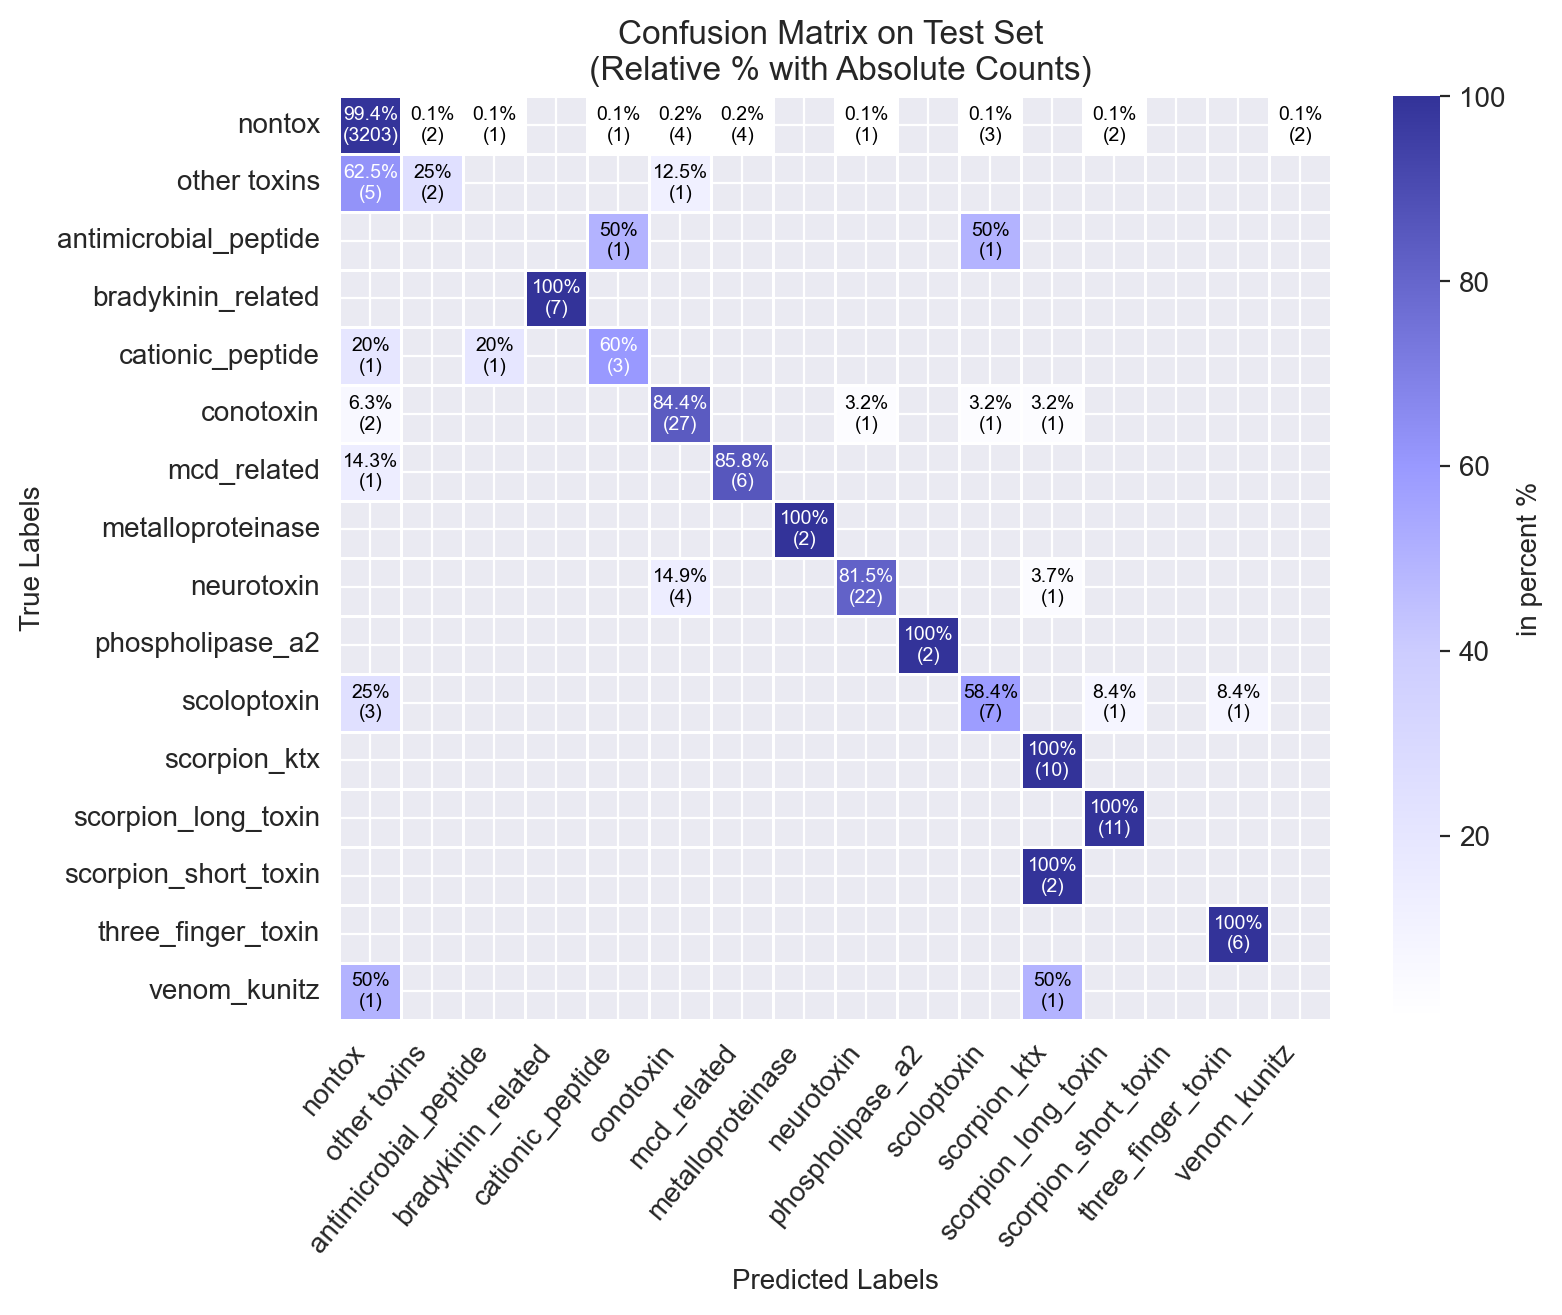

In [118]:
model.eval()
with torch.no_grad():
    outputs = model(X_test)
    _, predicted = torch.max(outputs, 1)

    # Compute accuracy and MCC
    accuracy = accuracy_score(y_test.numpy(), predicted.numpy())
    print(f"Test Accuracy: {accuracy:.4f}")

    mcc = matthews_corrcoef(y_test.numpy(), predicted.numpy())
    print(f"Test Matthews Correlation Coefficient (MCC): {mcc:.4f}")

    # Confusion matrix and percentage matrix
    predicted_labels = label_encoder.inverse_transform(predicted.numpy())
    true_labels = label_encoder.inverse_transform(y_test.numpy())
    cm = confusion_matrix(true_labels, predicted_labels)
    cm_percentage = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis] * 100

    # Define colors and colormap
    colors = [
        (1, 1, 1),         # White
        (0.9, 0.9, 1),     # Light lilac
        (0.8, 0.8, 1),     # Lilac
        (0.6, 0.6, 1),     # Medium lilac
        (0.4, 0.4, 0.8),   # Deep lilac
        (0.2, 0.2, 0.6),   # Dark lilac
    ]
    cmap = LinearSegmentedColormap.from_list("custom_lilac", colors)
    boundaries = [0, 1, 10, 20, 30, 40, 50, 60, 70, 80, 100]
    norm = BoundaryNorm(boundaries, cmap.N)

    # Create custom order
    custom_order = ["nontox", "other toxins"] + [cls for cls in label_encoder.classes_ if cls not in ["nontox", "other toxins"]]

    # Reorder confusion matrix and percentage matrix
    order_indices = [list(label_encoder.classes_).index(cls) for cls in custom_order]
    cm_reordered = cm[np.ix_(order_indices, order_indices)]
    cm_percentage_reordered = cm_percentage[np.ix_(order_indices, order_indices)]

    # Replace zeros with NaN for visualization
    cm_percentage_no_zeros = np.where(cm_reordered == 0, np.nan, cm_percentage_reordered)

    # Plot heatmap
    fig, ax = plt.subplots(figsize=(8, 6), dpi=200)

    sns.heatmap(
        cm_percentage_no_zeros,
        annot=False,
        cmap=cmap,
        xticklabels=custom_order,
        yticklabels=custom_order,
        cbar_kws={'label': 'in percent %'},
        fmt=".0f",
        linewidths=1,
        ax=ax,
    )
    plt.xticks(rotation=50, ha='right')
    plt.yticks(rotation=0)

    # Add text annotations
    for i in range(cm_reordered.shape[0]):
        for j in range(cm_reordered.shape[1]):
            if cm_reordered[i, j] > 0:
                percentage_value = cm_percentage_reordered[i, j]
                if percentage_value % 1 == 0:
                    relative_text = f"{percentage_value:.0f}%"
                elif (round(percentage_value, 2) * 10) % 1 == 0:
                    relative_text = f"{percentage_value:.1f}%"
                else:
                    relative_text = f"{math.ceil(percentage_value * 10) / 10:.1f}%"

                absolute_text = f"{cm_reordered[i, j]:d}"

                background_color = cmap(norm(percentage_value))
                brightness = (
                    background_color[0] * 0.299 +
                    background_color[1] * 0.587 +
                    background_color[2] * 0.114
                )
                font_color = 'white' if brightness < 0.5 else 'black'

                ax.text(
                    j + 0.5, i + 0.5,
                    f"{relative_text}\n({absolute_text})",
                    ha='center', va='center',
                    fontsize=7, color=font_color
                )

    # Titles and labels
    plt.title("Confusion Matrix on Test Set \n (Relative % with Absolute Counts)")
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')

    # Save and show the plot
    plt.savefig("cm_test.png", bbox_inches='tight')
    plt.show()


### ant toxins

In [119]:
ant_tox

,identifier,combined,embedding
178,A0A6M3Z9I6,"[-0.04453713074326515, 0.00853140652179718, 0....","[-0.04453713074326515, 0.00853140652179718, 0...."
412,P0DSI6,"[0.09179025888442993, 0.017110349610447884, -0...","[0.09179025888442993, 0.017110349610447884, -0..."
418,P0DSI4,"[-0.011715764179825783, 0.005947307217866182, ...","[-0.011715764179825783, 0.005947307217866182, ..."
437,P0DSI5,"[0.0917123481631279, 0.003579158568754792, -0....","[0.0917123481631279, 0.003579158568754792, -0...."
668,P0DX60,"[-0.02099231258034706, 0.03468887135386467, 0....","[-0.02099231258034706, 0.03468887135386467, 0...."


In [121]:
ANTS = torch.tensor(ant_tox['embedding'].to_list(), dtype=torch.float32)
identifiers = ant_tox['identifier'].to_list()

with torch.no_grad():
    outputs = model(ANTS)
    _, predicted_indices = torch.max(outputs, 1)

predicted_labels = label_encoder.inverse_transform(predicted_indices.numpy())

for idx, identifier in enumerate(identifiers):
    print(f"Identifier: {identifier}")
    print(predicted_labels[idx])

Identifier: A0A6M3Z9I6
nontox
Identifier: P0DSI6
conotoxin
Identifier: P0DSI4
conotoxin
Identifier: P0DSI5
conotoxin
Identifier: P0DX60
nontox
